In [1]:
import shutil
import os.path as osp
from pathlib import Path
from natsort import natsorted
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'torwic':
    os.chdir('../..')
print(os.getcwd())

# for evo ######################################################################
from evo.core import metrics
from evo.core.units import Unit

from evo.tools import log
log.configure_logging(verbose=False, debug=False, silent=True)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

# plot.apply_settings(SETTINGS)

from evo.tools import file_interface
#############################################################################


/mnt/C45ADD865ADD7620/i3d-rrc/ic-topo-nav/mickst3r


In [2]:
# %matplotlib widget
%matplotlib inline

traj_query_tum_file = "./data/filtered_query_poses.txt"
traj_ref_tum_file = "./data/retrieved_ref_poses.txt"
traj_pred_kitti_file = "./data/pred_image_right_poses_kitti_query_down.txt"

# create copies of all these files with just the first 60 lines
traj_query_tum_file_60 = "./data/filtered_query_poses_60.txt"
traj_ref_tum_file_60 = "./data/retrieved_ref_poses_60.txt"
traj_pred_kitti_file_60 = "./data/pred_image_right_poses_kitti_query_down_60.txt"

shutil.copyfile(traj_query_tum_file, traj_query_tum_file_60)
shutil.copyfile(traj_ref_tum_file, traj_ref_tum_file_60)
shutil.copyfile(traj_pred_kitti_file, traj_pred_kitti_file_60)

# read the first 60 lines of each file
with open(traj_query_tum_file_60, 'r') as f:
    lines = f.readlines()
    with open(traj_query_tum_file_60, 'w') as f_out:
        f_out.writelines(lines[:60])
        
with open(traj_ref_tum_file_60, 'r') as f:
    lines = f.readlines()
    with open(traj_ref_tum_file_60, 'w') as f_out:
        f_out.writelines(lines[:60])
        
with open(traj_pred_kitti_file_60, 'r') as f:
    lines = f.readlines()
    with open(traj_pred_kitti_file_60, 'w') as f_out:
        f_out.writelines(lines[:60])

# read using evo
traj_query_tum = file_interface.read_tum_trajectory_file(traj_query_tum_file_60)
traj_ref_tum = file_interface.read_tum_trajectory_file(traj_ref_tum_file_60)
traj_pred_kitti = file_interface.read_kitti_poses_file(traj_pred_kitti_file_60)

In [3]:
import copy
traj_pred_aligned = copy.deepcopy(traj_pred_kitti)
traj_pred_aligned.align(traj_query_tum, correct_scale=True, correct_only_scale=False)
traj_pred_aligned.align_origin(traj_query_tum)

array([[-0.42311037, -0.79157446, -0.44088855, -0.37913425],
       [ 0.16778247,  0.40972769, -0.89664378, -0.03659147],
       [ 0.89040602, -0.45335422, -0.0405454 , -0.27759037],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

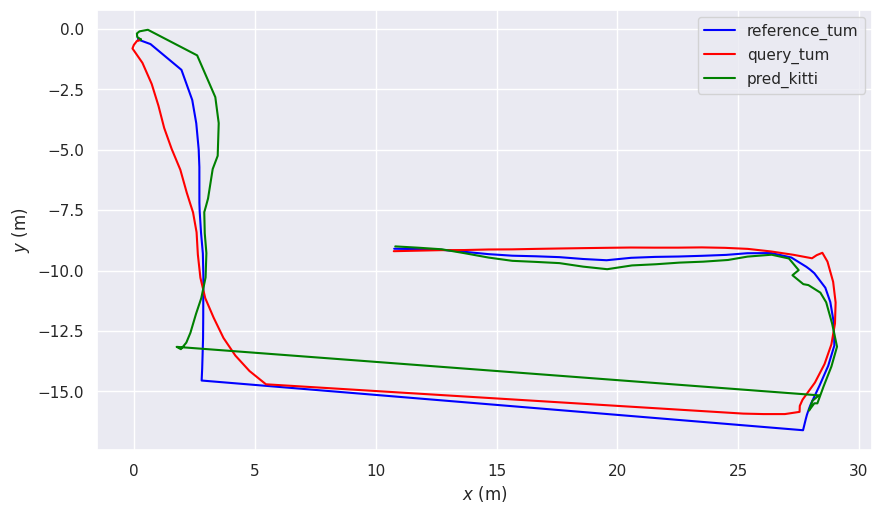

In [4]:
fig = plt.figure(figsize=(10, 20))
traj_by_label = {
    "reference_tum": traj_ref_tum, 
    "query_tum": traj_query_tum,
    "pred_kitti": traj_pred_kitti
}

plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
plt.show()

{'max': 4.01145101798464,
 'mean': 0.8455662736339868,
 'median': 0.5995416019940912,
 'min': 0.05621072105034625,
 'rmse': 1.199811629586099,
 'sse': 86.37287678940301,
 'std': 0.8512142053459771}


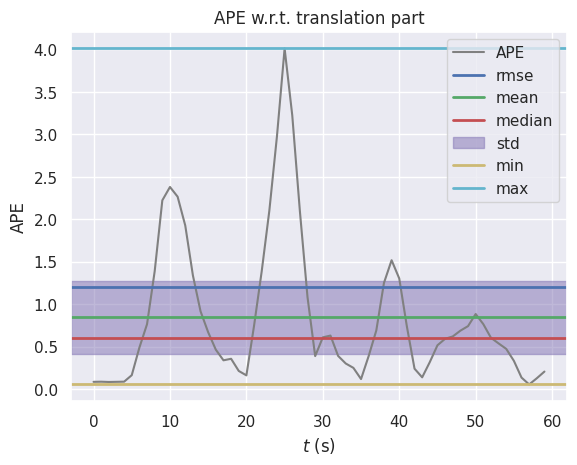

In [5]:
pose_relation = metrics.PoseRelation.translation_part
use_aligned_trajectories = False

if use_aligned_trajectories:
    data = (traj_query_tum, traj_pred_kitti) 
else:
    data = (traj_query_tum, traj_pred_kitti)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

START_POSE = 0
END_POSE = 60

# create an x array with the time in seconds corresponding to each pose
seconds_from_start = list(range(START_POSE, END_POSE))

fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

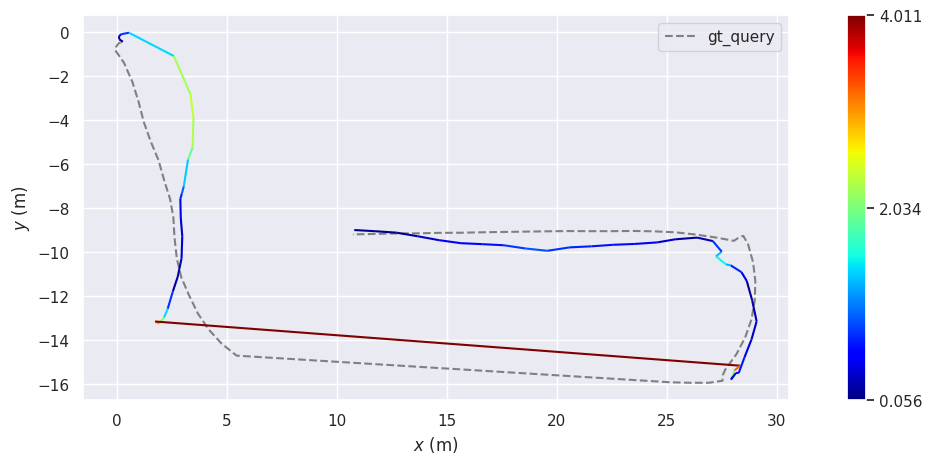

In [6]:
plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(15, 5))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_query_tum, '--', "gray", "gt_query")
plot.traj_colormap(ax, traj_pred_kitti if use_aligned_trajectories else traj_pred_kitti, ape_metric.error, plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()